### accelerate 加速训练模型

### 一、相关环境
#### 1、系统环境
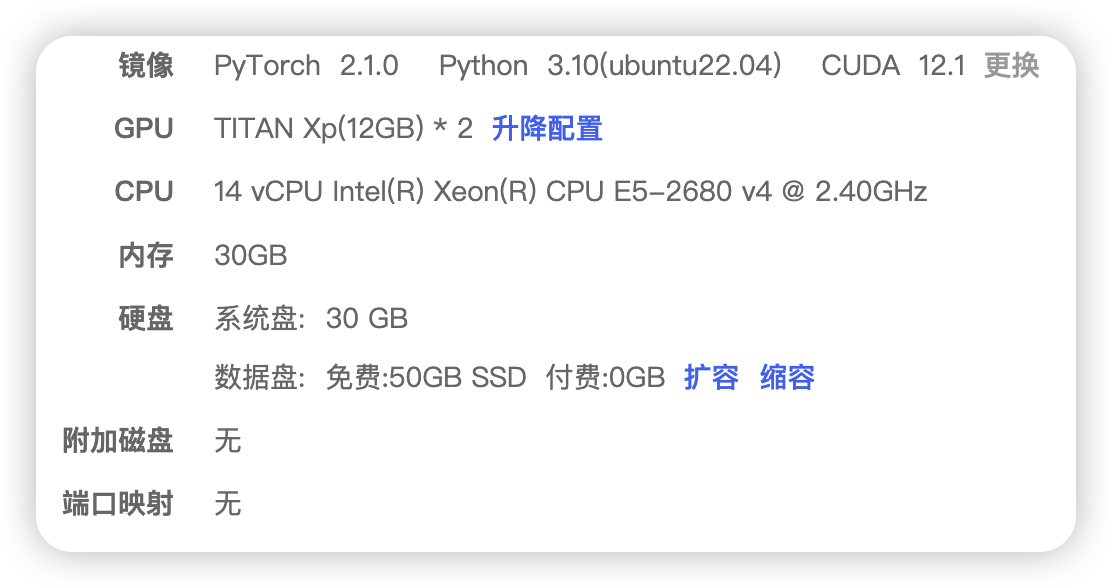
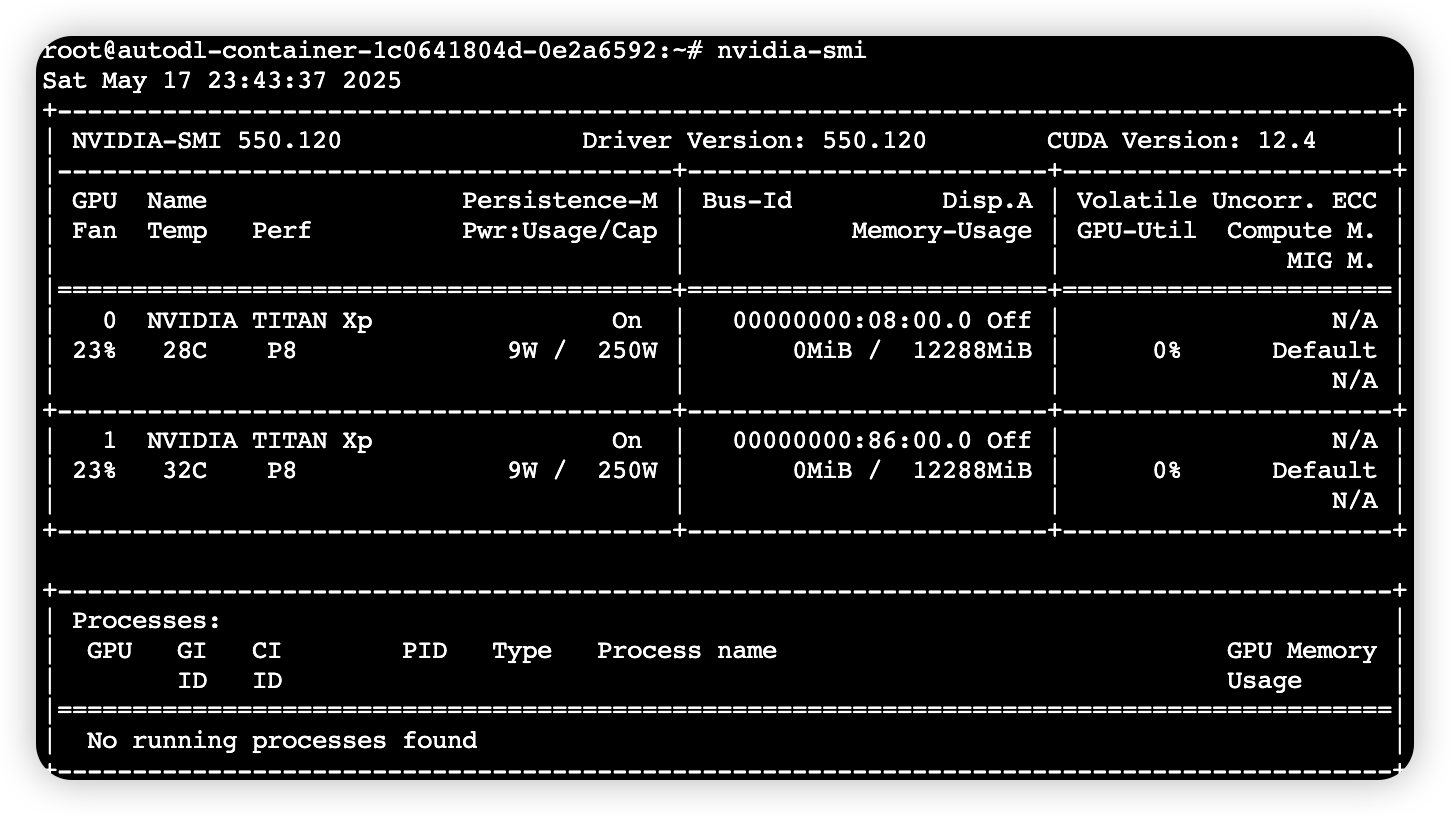

#### 2、python 相关库

In [ ]:
!pip install accelerate
!pip install deepspeed
!pip install torch
!pip install torchvision
!pip install transformers

### 二、配置 accelerate 配置文件
#### 1、配置方式一

In [ ]:
终端执行下述命令：
accelerate config
执行显示如下，然后按照提示进行操作：

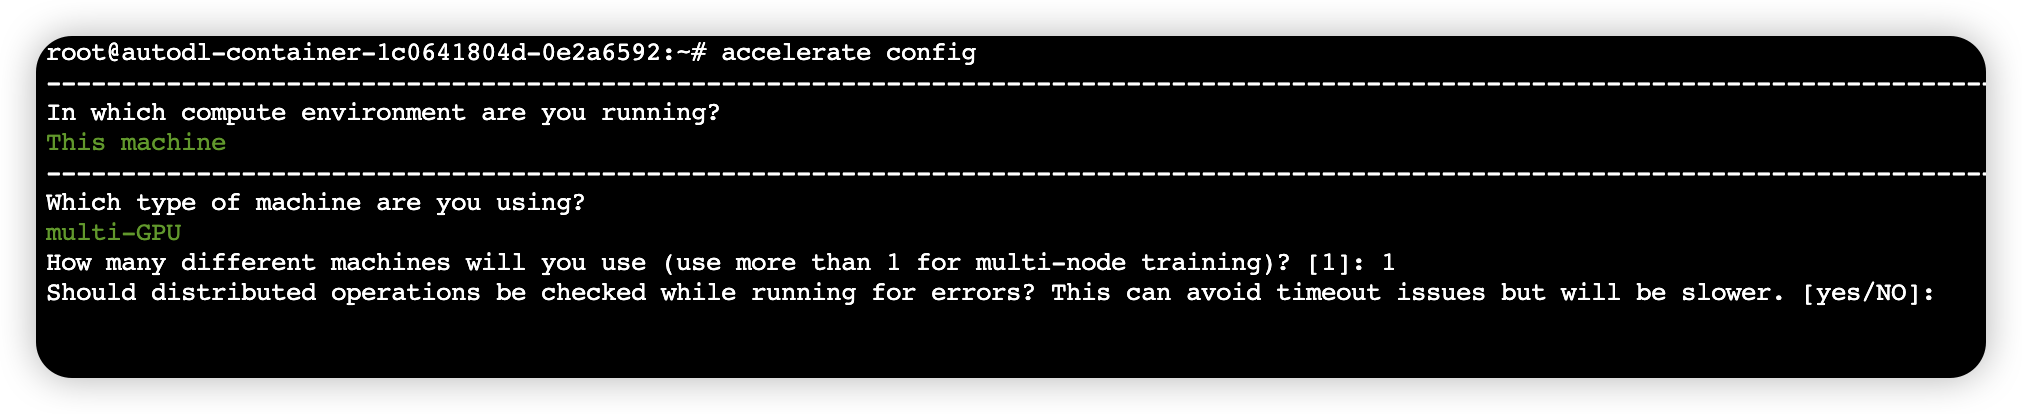

#### 2、配置方式二

In [ ]:
在终端执行下述命令，生成默认 accelerate 配置文件：
python -c "from accelerate.utils import write_basic_config; write_basic_config(mixed_precision='fp16')"
执行结果如下：

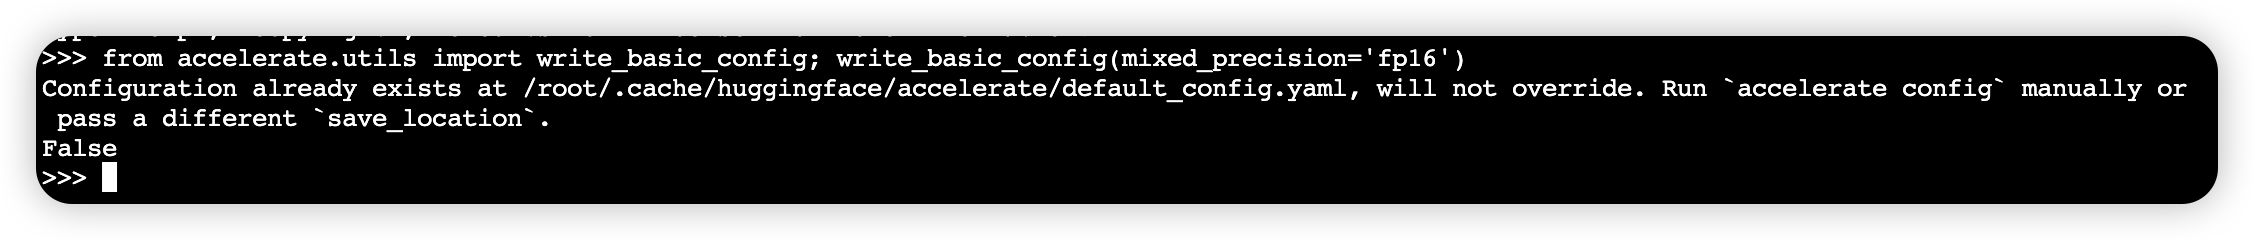

先将 mixed_precision 改为 no
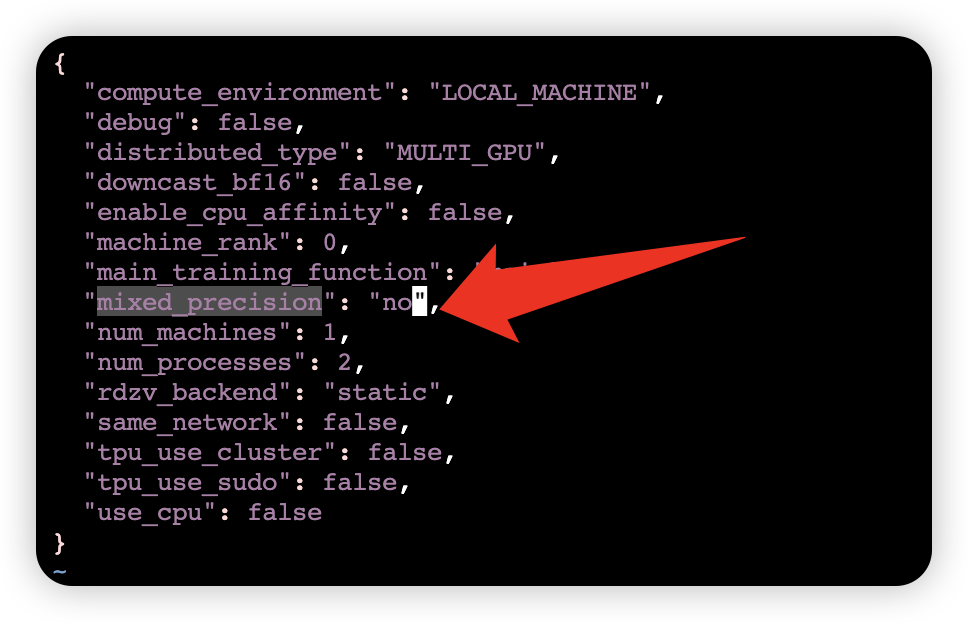

#### 3、查看位置文件内容

In [ ]:
在终端执行下述命令，查看 配置文件 内容，检查配置是否正常
accelerate env
执行结果如下：

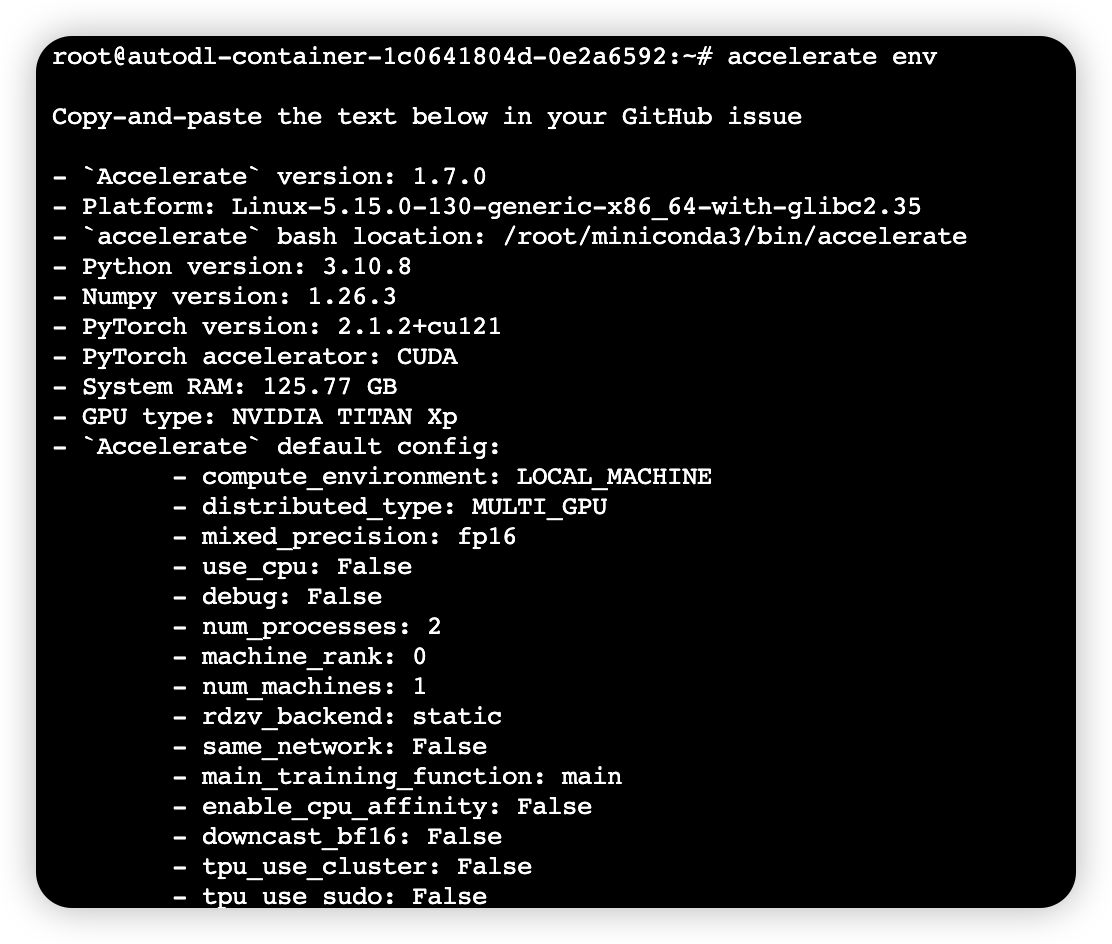

#### 4、测试环境是否正常

In [ ]:
在终端执行下述命令，判断环境是否正常
accelerate test
执行 成功 结果如下：

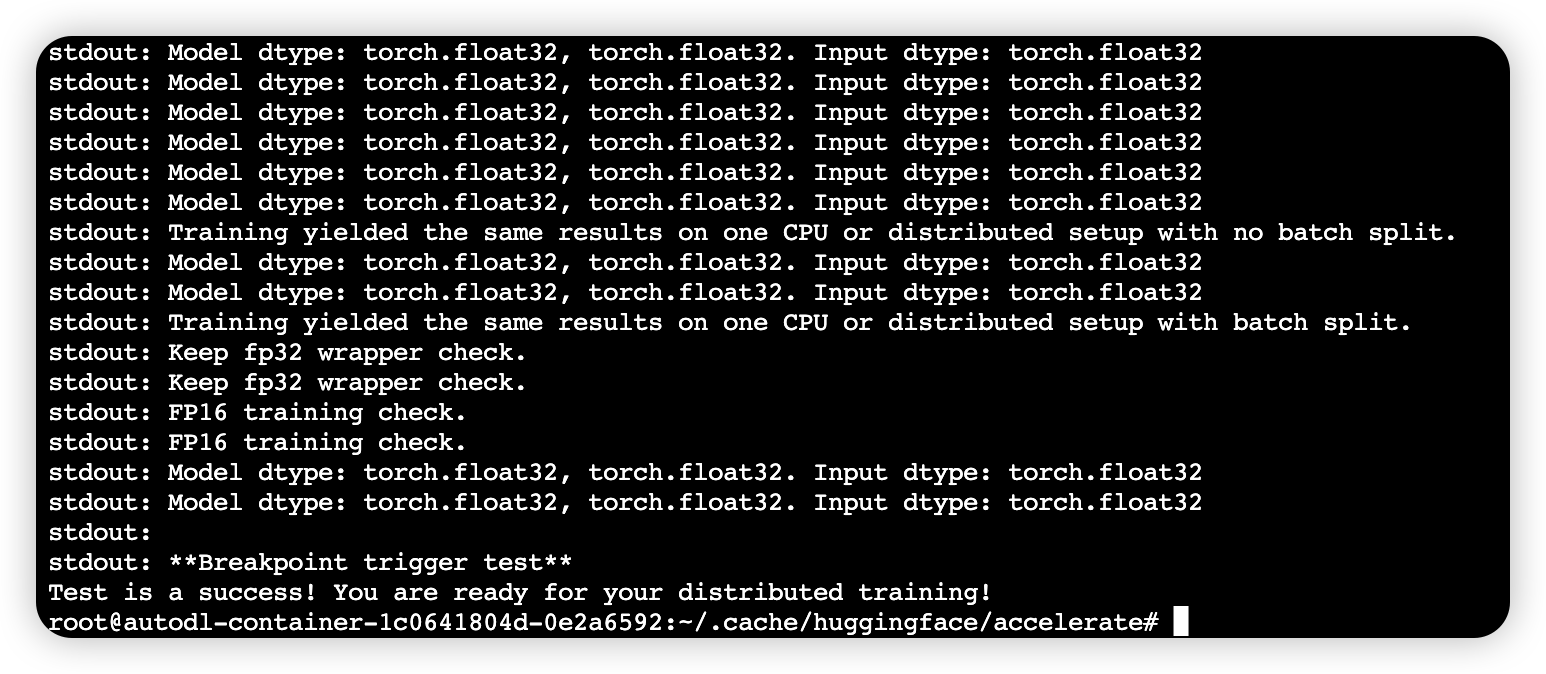

### 三、使用 accelerate 训练模型

In [2]:
#导入环境
from accelerate import Accelerator, DeepSpeedPlugin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#定义数据集，并进行处理
# 1. 定义数据转换（预处理）
transform = transforms.Compose([
    transforms.ToTensor(),          # 转为Tensor格式（自动归一化到0-1）
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化（MNIST的均值和标准差）
])

def load_data():
    # 2. 下载数据集
    train_data = datasets.MNIST(
        root='data',          # 数据存储路径
        train=True,           # 训练集
        download=True,        # 自动下载
        transform=transform   # 应用预处理
    )
    
    test_data = datasets.MNIST(
        root='data',
        train=False,          # 测试集
        transform=transform
    )
    
    # 3. 创建数据加载器（自动分批次）
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)
    return train_loader, test_loader

In [4]:
#定义模型结构
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 卷积层组合
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3),   # 输入1通道，输出32通道，3x3卷积核
            nn.ReLU(),              # 激活函数
            nn.MaxPool2d(2),        # 最大池化（缩小一半尺寸）

            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 全连接层
        self.fc_layers = nn.Sequential(
            nn.Flatten(),           # 展平多维数据
            nn.Linear(64*5*5, 128), # 输入维度需要计算（后面解释）
            nn.ReLU(),
            nn.Linear(128, 10)      # 输出10个数字的概率
    )

    def forward(self, x):
        x = self.conv_layers(x)     # 通过卷积层
        x = self.fc_layers(x)       # 通过全连接层
        return x


In [7]:
#ac_train.py

#导入环境
from accelerate import Accelerator, DeepSpeedPlugin
import torch
from torch.utils.data import DataLoader, TensorDataset
from model_definition import load_data, CustomModel


if __name__ == '__main__':

    #加载数据
    train_loader, test_loader = load_data()
    #定义模型
    model = CustomModel()

    #定义 accelerate 实例，并使用 deepspeed 插件
    deepspeed_plugin = DeepSpeedPlugin(zero_stage=2, gradient_clipping=1.0)
    accelerator = Accelerator(deepspeed_plugin=deepspeed_plugin)

    #定义 优化器、损失函数
    optimization = torch.optim.Adam(model.parameters(), lr=0.00015)
    crition = torch.nn.MSELoss()

    #将 模型、数据集、优化器 进行包装
    model, train_loader, optimization = accelerator.prepare(model, train_loader, optimization)

    for epoch in range(1000):
        model.train()
        for batch in train_loader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = crition(outputs, labels)
            
            optimization.zero_grad()
            accelerator.backward(loss)
            optimization.step()
        print(f"Epoch {epoch} loss: {loss.item()}")
            
    accelerator.save(model.state_dict(), "./model_save/model.pth")


- 修改配置文件
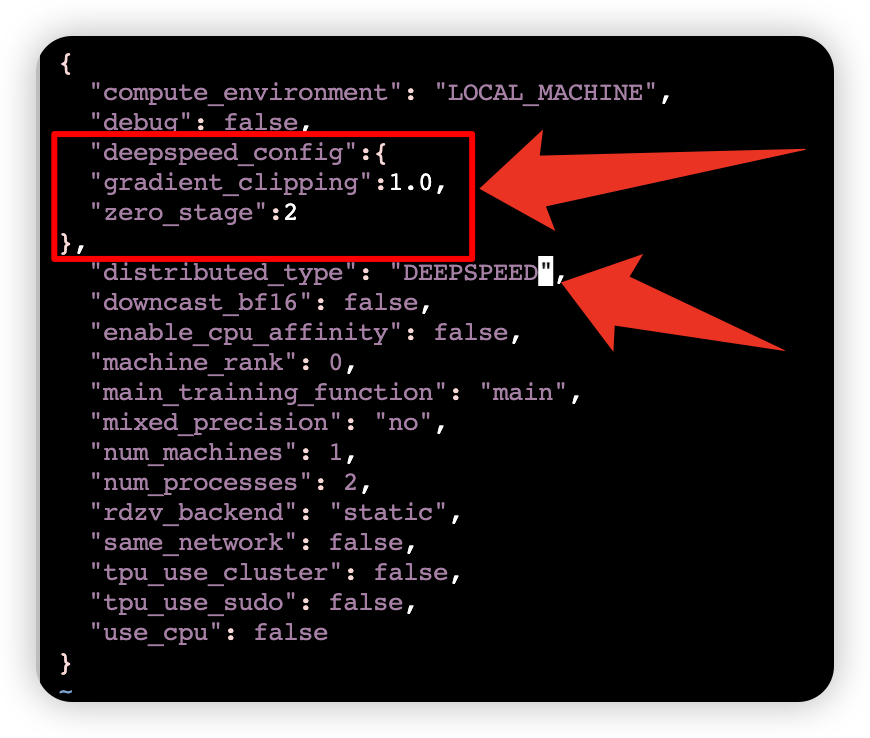

In [ ]:
#执行训练
#终端输入下方命令
accelerate launch ac_train.py


- 执行训练显示
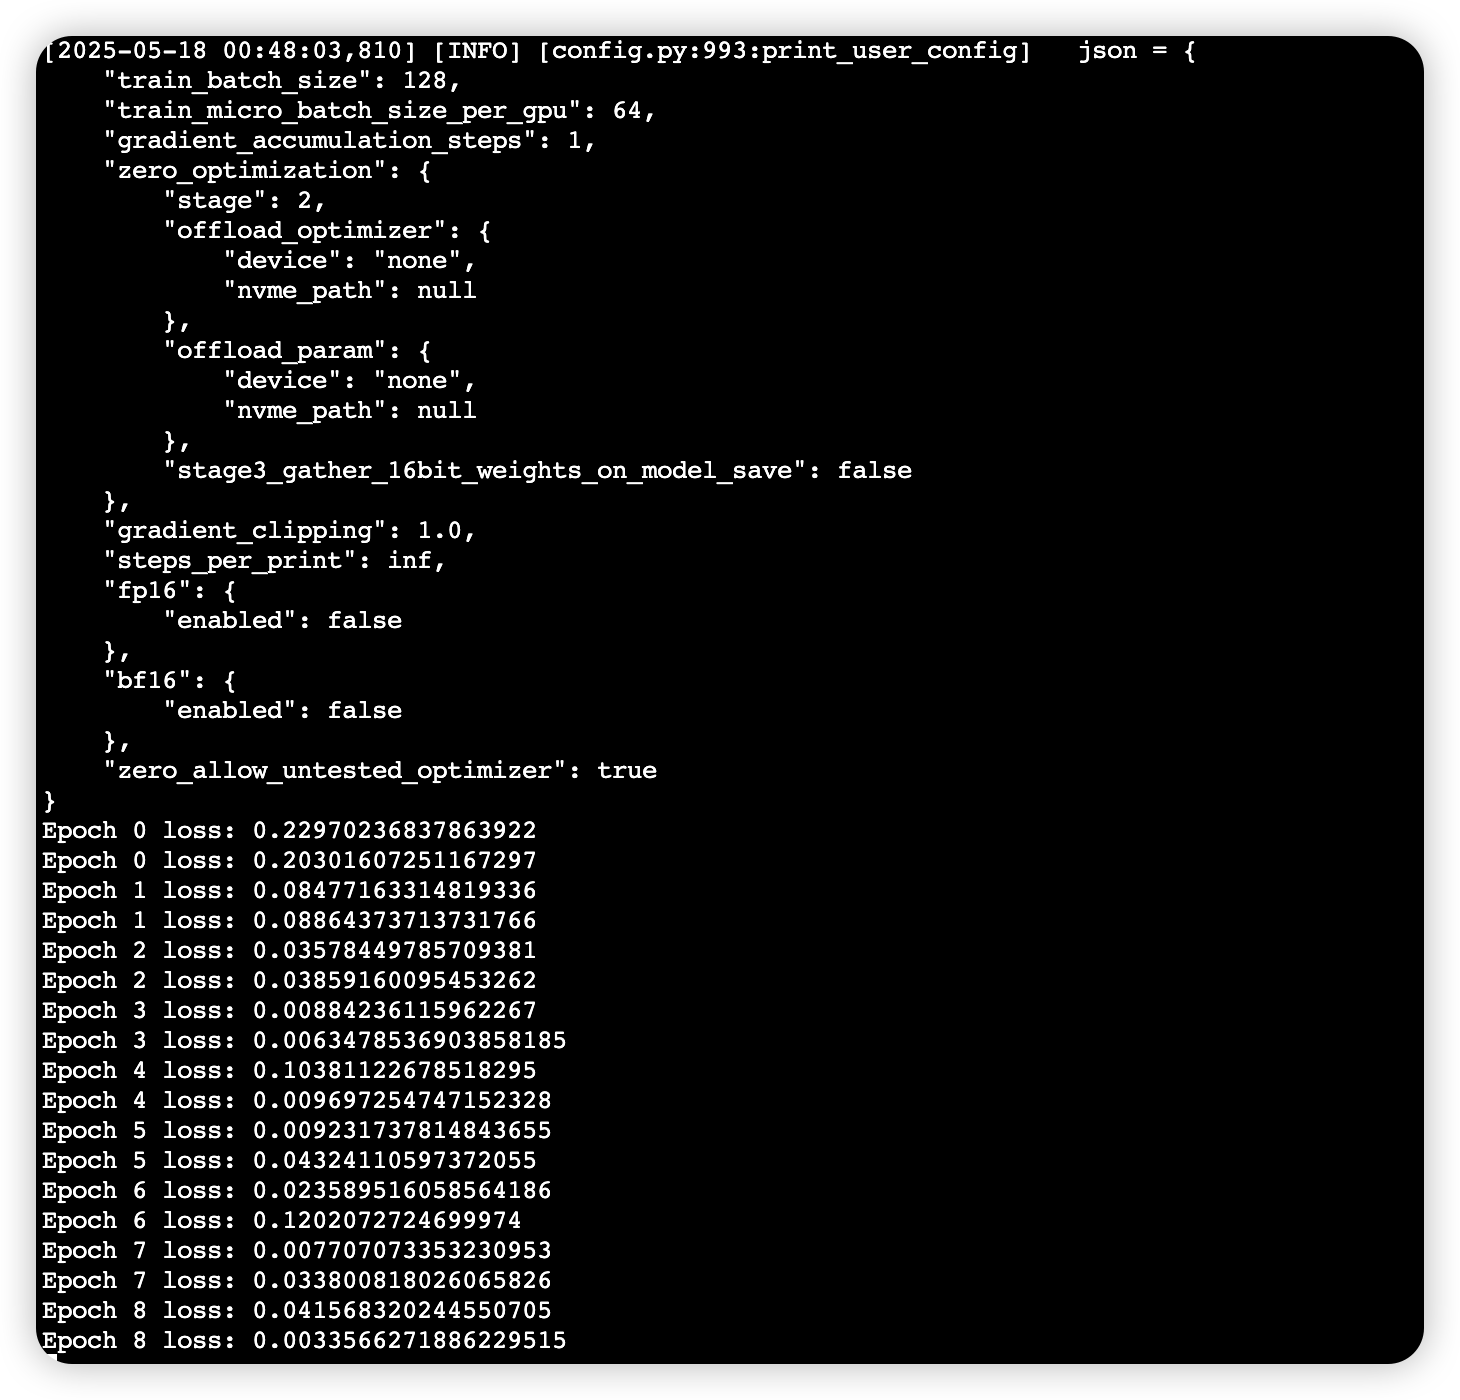

- GPU 显存变化
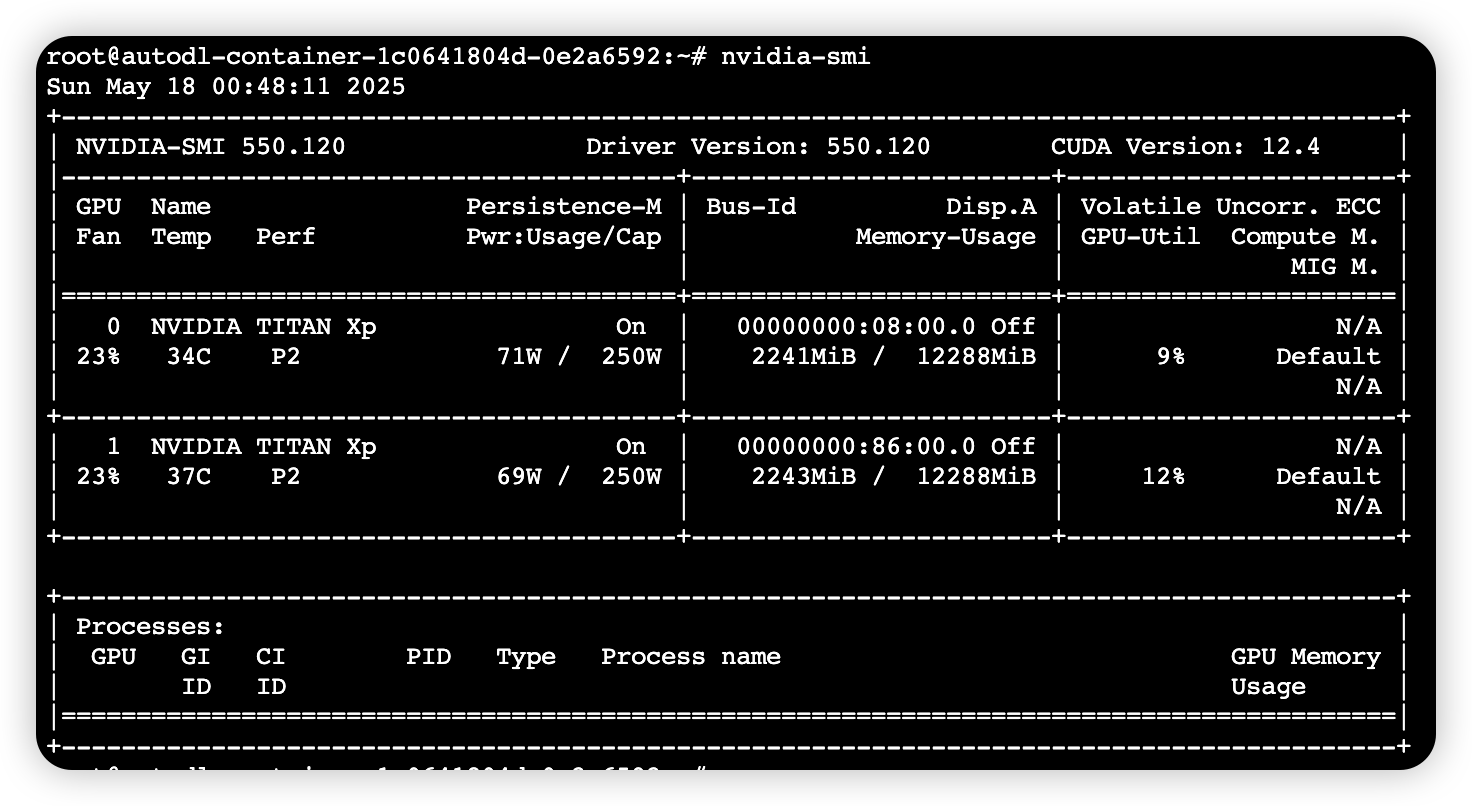